In [2]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.filterwarnings('ignore')

/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [70]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

hmc_kernel = pyro.infer.NUTS(gpmodel.model)

mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=10000, warmup_steps = 1000)
    
mcmc.run()
mcmc


Sample: 100%|██████████| 11000/11000 [08:46, 20.91it/s, step size=2.31e-01, acc. prob=0.900]


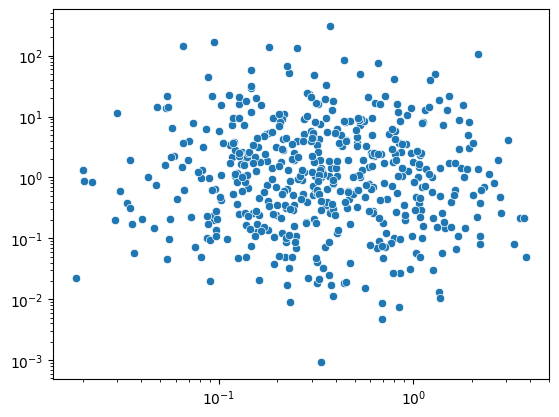

In [41]:
lengthprior = torch.distributions.LogNormal(-1, 1)
varianceprior = torch.distributions.LogNormal(0, 2)
x1 = lengthprior.sample_n(500)
y1 = varianceprior.sample_n(500)

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1)
plt.show()


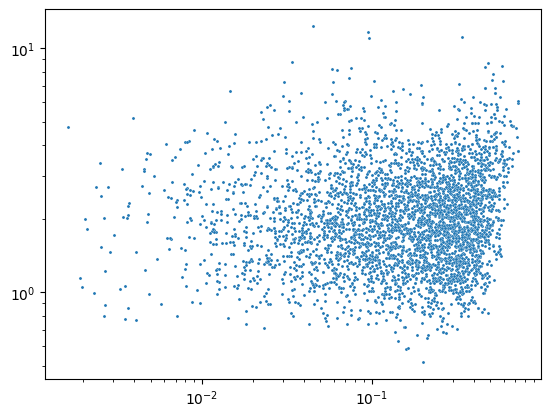

In [43]:
hyperparam = mcmc.get_samples()
x1 = hyperparam["kernel.lengthscale"]
y1 = hyperparam["kernel.variance"]

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1, s = 5)
plt.show()

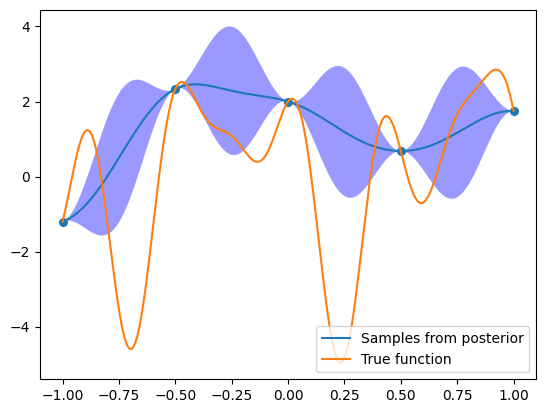

In [71]:
with torch.no_grad():
    x_new = torch.linspace(-1, 1, 1000)
    y_new = gpmodel.forward(x_new)[0] # Returns the mean of our posterior samples
    sd_new = gpmodel.forward(x_new)[1] # Returns the standard deviation of our posteriour samples
    f, ax = plt.subplots(1)
    sns.lineplot(x = x_new, y = y_new, ax=ax, label = "Samples from posterior")
    sns.scatterplot(x = X, y = y, ax=ax, s = 50)
    ax.fill_between(x_new, y_new+2*sd_new, y_new-2*sd_new, facecolor='blue', alpha=0.4)
    sns.lineplot(x = x_new, y = target_func(x_new), ax = ax, label =  "True function")
    ax.legend(loc='lower right')
    plt.show()
    

In [45]:
diag = az.from_pyro(mcmc)

a = az.ess(diag)
print(a)
# az.plot_trace(diag, compact=True)

<xarray.Dataset>
Dimensions:             ()
Data variables:
    kernel.lengthscale  float64 682.9
    kernel.variance     float64 1.681e+03


In [48]:
sum1 = az.summary(diag)
params =  az.extract(diag)

samples_kernel_lengthscale = params["kernel.lengthscale"].to_numpy()
samples_kernel_variance = params["kernel.variance"].to_numpy()

print(sum1)
"""
xs = np.arange(1, 201, 1)

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")

sns.histplot(x = samples_kernel_lengthscale, ax = ax)
sns.histplot(x = samples_kernel_variance, ax = ax)


lengthscale_essbulk = sum1["ess_bulk"][0]
variance_essbulk = sum1["ess_bulk"][1]
lengthscale_ess_tail = sum1["ess_tail"][0]
variance_ess_tail = sum1["ess_tail"][1]

print(lengthscale_essbulk/200)
print(variance_essbulk/200)
print(lengthscale_ess_tail/200)
print(variance_ess_tail/200)
"""



arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.215  0.155   0.002    0.477      0.006    0.004   
kernel.variance     2.217  1.134   0.715    4.155      0.030    0.021   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     683.0     909.0    NaN  
kernel.variance       1681.0    1560.0    NaN  


'\nxs = np.arange(1, 201, 1)\n\nf, ax = plt.subplots()\nax.set(xscale="log", yscale="log")\n\nsns.histplot(x = samples_kernel_lengthscale, ax = ax)\nsns.histplot(x = samples_kernel_variance, ax = ax)\n\n\nlengthscale_essbulk = sum1["ess_bulk"][0]\nvariance_essbulk = sum1["ess_bulk"][1]\nlengthscale_ess_tail = sum1["ess_tail"][0]\nvariance_ess_tail = sum1["ess_tail"][1]\n\nprint(lengthscale_essbulk/200)\nprint(variance_essbulk/200)\nprint(lengthscale_ess_tail/200)\nprint(variance_ess_tail/200)\n'

In [ ]:
warmup_array = np.array([10, 25, 50, 100, 150, 300, 400, 500])
diag_array = np.empty([warmup_array.size, 4])
mean_calc_arrary = np.empty([4,4])


for i in range(warmup_array.size):
    print(str(i) + ": Start")
    for j in range(4):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

        hmc_kernel = pyro.infer.NUTS(gpmodel.model)

        mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=2000, warmup_steps = warmup_array[i])
        mcmc.run()
        print(str(i) + ": past MCMC")
        
        diag = az.from_pyro(mcmc)
        params =  az.extract(diag)
        print(str(i) + ": past arviz")
        sum2 = az.summary(diag)
        mean_calc_arrary[j][0] = sum2["ess_bulk"][0]/500
        mean_calc_arrary[j][1] = sum2["ess_bulk"][1]/500
        mean_calc_arrary[j][2] = sum2["ess_tail"][0]/500
        mean_calc_arrary[j][3] = sum2["ess_tail"][1]/500


    diag_array[i][0] = np.mean(mean_calc_arrary, axis = 0)[0]#sum2["ess_bulk"][0]/500
    diag_array[i][1] = np.mean(mean_calc_arrary, axis = 0)[1]#sum2["ess_bulk"][1]/500
    diag_array[i][2] = np.mean(mean_calc_arrary, axis = 0)[2]#sum2["ess_tail"][0]/500
    diag_array[i][3] = np.mean(mean_calc_arrary, axis = 0)[3]#sum2["ess_tail"][1]/500



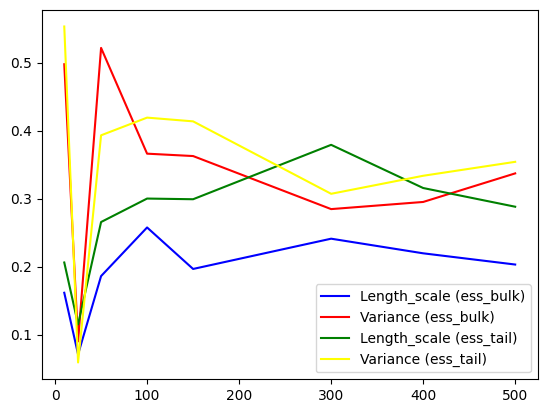

In [50]:
"""sns.lineplot(x = warmup_array, y = diag_array[:, 0])
sns.lineplot(x = warmup_array, y = diag_array[:, 1])
sns.lineplot(x = warmup_array, y = diag_array[:, 2])
sns.lineplot(x = warmup_array, y = diag_array[:, 3])
"""
f, ax = plt.subplots(1, 1)

ax.plot(warmup_array, diag_array[:, 0], color="blue", label="Length_scale (ess_bulk)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 1], color="red", label="Variance (ess_bulk)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 2], color="green", label="Length_scale (ess_tail)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 3], color="yellow", label="Variance (ess_tail)", linestyle="-")

ax.legend(loc='lower right')

plt.show()



# PART 2

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.filterwarnings('ignore')

/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [20]:
x_test = torch.linspace(-1, 1, 200, dtype = torch.float64)
noise = torch.tensor(1e-3, dtype=torch.float64)



In [43]:

#for i in range(2):
    #print(i)
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0, dtype = torch.float64), torch.tensor(1.0, dtype = torch.float64)))
print(gpmodel.kernel.variance.item())
kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0, dtype = torch.float64), torch.tensor(2.0, dtype = torch.float64)))
print(gpmodel.kernel.lengthscale.item())
gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4, dtype = torch.float64))

hmc_kernel = pyro.infer.NUTS(gpmodel.model)

mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=200, warmup_steps = 100)
mcmc.run()

cov = gpmodel.kernel.forward(x_test) + noise.expand(200).diag()

samples = dist.MultivariateNormal(torch.zeros(200, dtype = torch.float64), covariance_matrix=cov, validate_args = False).sample(sample_shape=(1,))


min_value, min_idx = torch.min(samples[0], dim = 0, keepdim=False)
xstar = x_test[min_idx.item()].reshape(1)
fstar = target_func(xstar)
X = torch.cat((X, xstar), 0)
y = torch.cat((y, fstar), 0)
sns.lineplot(x = x_test, y = samples[0])
plt.scatter(xstar, min_value, marker='o', s=50)
plt.show()

"""
print(min_value)
print(x_test[min_idx.item()])
print(x_test[min_idx.item()])
s
"""


0.25816896019296987
59.81670832048063


Sample: 100%|██████████| 300/300 [00:08, 35.50it/s, step size=5.48e-01, acc. prob=0.913]


_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 105 is not positive-definite).

In [19]:
print(X)
print(y)

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
tensor([-1.1983,  2.3341,  2.0000,  0.6815,  1.7453])


In [38]:
gpmodel.kernel.variance.item()

0.13605198156758497